# Interactive TFX Training Pipeline

This notebook walks through the TFX training pipeline, in an interactive setting, which builds a model to solve for the foreign exchange use case detailed below.

## Foreign exchange use case

The Relative Strength Index, or RSI, is a financial technical indicator that measures the magnitude of recent price changes to evaluate whether an asset is currently overbought or oversold. See https://www.investopedia.com/terms/r/rsi.asp for further details. <br>
<br>
The rule of thumb regarding RSI is:
- When RSI for an asset is less than 30, traders should buy this asset as the price is expected to increase in the near future.
- When RSI for an asset is greater than 70, traders should sell this asset as the price is expected to decrease in the near future.

As this is a rule of thumb, this strategy cannot be trusted to work favorably at all times. Therefore, in these instances (i.e. RSI > 70 or RSI < 30), it would be useful to know if RSI is a reliable indicator to inform a trade or not. <br>

We propose that, for a given asset, RSI is a reliable indicator when other metrics describing the same asset (e.g. log returns) are behaving as they usually do when RSI > 70 or RSI < 30. And therefore, RSI is unreliable to inform a trade when these other metrics (describing the same asset) are behaving anomalously. <br>

To detect when RSI is reliable or not for a given asset, the modelling approach is as follows. An anomaly detection model will be trained to learn the expected behaviour of other metrics describing the asset when RSI > 70 or RSI < 30. When an anomaly is detected (and RSI > 70 or RSI < 30), the model is informing that these input metrics are behaving differently to how they usually behave when RSI > 70 or RSI < 30. And so in these instances, RSI is not reliable and a trade is not advised. If no anomaly is detected, then the other metrics are behaving as expected when RSI > 70 or RSI < 30, so you can trust RSI and make a trade.

### Import Python packages

In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
import tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.4.1
TFX version: 0.28.0


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
import sys
import absl
import matplotlib.pyplot as plt
import google.auth

tf.get_logger().propagate = False

from tfx.components import StatisticsGen
from tfx.components import SchemaGen
from tfx.components import ExampleValidator
from tfx.components import Transform
from tfx.components import Trainer
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import trainer_pb2

# Set default logging level
absl.logging.set_verbosity(absl.logging.INFO)

In [3]:
# Ensures TFX outputs from previous executions are removed before restarting the pipeline
!rm -r pipelines/forex-example-pipeline

### Instantiate TFX interactive context

The TFX interactive context will allow us to explore the outputs of each TFX component.

In [4]:
# Setup access to BigQuery
credentials, gcp_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Pipeline name to configure save location
PIPELINE_NAME = "forex-example-pipeline"

# Create TFX interactive context
context = InteractiveContext(
    pipeline_name=PIPELINE_NAME,
    pipeline_root=os.path.join('pipelines', PIPELINE_NAME),
    beam_pipeline_args=[
        f"--project={gcp_project_id}",
        f"--temp_location=gs://{gcp_project_id}_dataflow",
    ]
)

### Set constants to be used throughout the TFX pipeline

Here we set the currency pair we will predict anomalies for, date of training and evaluation data, window size of LSTM model, model features, number of hidden units in the model, and batch size for training. 

In [5]:
CCY_PAIR = 'GBPAUD'

TRAIN_START = '2021-05-22 0:00:00'
TRAIN_END = '2021-05-23 0:00:00'
EVAL_START = '2021-05-23 0:00:00'
EVAL_END = '2021-05-24 0:00:00'

WINDOW_SIZE = 30

METRIC_COLUMNS = ['SIMPLE_MOVING_AVERAGE',
                  'EXPONENTIAL_MOVING_AVERAGE',
                  'STANDARD_DEVIATION',
                  'LOG_RTN']
NUM_FEATURES = len(METRIC_COLUMNS)

OUTER_UNITS = 32
INNER_UNITS = 16

BATCH_SIZE = 32

### ExampleGen component

Read data using custom ExampleGen component that computes sliding windows with a specified size via 'window_length' input argument. <br>
Notice in the SQL query the 'where' clause filters for GBPAUD, the RSI condition, and date. We filter for the RSI condition here so that while the anomaly detection model is training, it only sees the metrics (features) when this condition is true. Therefore the model will only learn the distributions of these metrics (features) when this condition is true.

In [6]:
sys.path.append('../app/python') # Update this path according to your notebook's working directory

from src.tfx_components.bigquery_window_gen import BigQueryExampleWithSlidingWindowGen
from tfx.proto.example_gen_pb2 import Input

example_gen = BigQueryExampleWithSlidingWindowGen(
    window_length=WINDOW_SIZE,
    bq_timestamp_attribute='timestamp',
    drop_irregular_windows=True,
    input_config=Input(splits=[
        Input.Split(name='train', pattern=f"""SELECT {', '.join(METRIC_COLUMNS)}, timestamp 
                                              FROM {gcp_project_id}.forex.metrics 
                                              WHERE symbol = '{CCY_PAIR}' 
                                                  AND (RELATIVE_STRENGTH_INDICATOR > 70 OR RELATIVE_STRENGTH_INDICATOR < 30) 
                                                  AND timestamp BETWEEN TIMESTAMP('{TRAIN_START}') AND TIMESTAMP('{TRAIN_END}')
                                              ORDER BY timestamp"""),
        Input.Split(name='eval', pattern=f"""SELECT {', '.join(METRIC_COLUMNS)}, timestamp
                                             FROM {gcp_project_id}.forex.metrics 
                                             WHERE symbol = '{CCY_PAIR}' 
                                                 AND (RELATIVE_STRENGTH_INDICATOR > 70 OR RELATIVE_STRENGTH_INDICATOR < 30) 
                                                 AND timestamp BETWEEN TIMESTAMP('{EVAL_START}') AND TIMESTAMP('{EVAL_END}') 
                                             ORDER BY timestamp"""),
    ])
)

context.run(example_gen)

INFO:absl:Running driver for BigQueryExampleWithSlidingWindowGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for BigQueryExampleWithSlidingWindowGen
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmpkgvrrvni/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmpkgvrrvni/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmpkgvrrvni/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmpkgvrrvni/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Generating examples.


/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(
INFO:absl:Examples generated.
INFO:absl:Running publisher for BigQueryExampleWithSlidingWindowGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: BigQueryExampleWithSlidingWindowGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "pipelines/forex-example-pipeline/BigQueryExampleWithSlidingWindowGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "examples"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "BigQueryExampleWithSlidingWindowGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

#### Extract output of ExampleGen

Use the function below to convert the output of ExampleGen into a Pandas dataframe.

In [7]:
def convert_example_gen_output_to_pandas_df(example_gen, sample_size, train_or_eval = 'train'):
    
    # Get the URI of the output artifact
    train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, train_or_eval)

    # Get the list of files in this directory (all compressed TFRecord files)
    tfrecord_filenames = [os.path.join(train_uri, name)
                          for name in os.listdir(train_uri)]

    # Create a `TFRecordDataset` to read these files
    dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
    
    output = []
    for tfrecord in dataset.take(sample_size):
        # Parse tfrecord to proto
        serialized_example = tfrecord.numpy()
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        features = example.features.feature
        
        # Convert proto to dict - note this extracts only the last element of each window
        instance = {}
        for key in features:
            
            if key == 'timestamp':
                # Extract the time bounds
                instance['end_time'] = datetime.fromtimestamp(int(features['timestamp'].int64_list.value[WINDOW_SIZE-1]))
            else:
                # Extract data
                instance[key] = features[key].float_list.value[WINDOW_SIZE-1]
        
        # Append instance as dict to list
        output.append(instance)
    
    df = pd.DataFrame(output)
    df.set_index('end_time', inplace=True)
    df.sort_index(inplace=True)
    
    return df


training_data_df = convert_example_gen_output_to_pandas_df(example_gen, sample_size=50000)
training_data_df.head()

,STANDARD_DEVIATION,LOG_RTN,SIMPLE_MOVING_AVERAGE,EXPONENTIAL_MOVING_AVERAGE
end_time,,,,
2021-05-22 00:00:29,0.000894,-5.391014e-06,1.800990,1.799317
2021-05-22 00:00:30,0.000895,1.174999e-06,1.800978,1.799313
2021-05-22 00:00:31,0.000897,-5.889017e-06,1.800967,1.799306
2021-05-22 00:00:32,0.000899,-9.757047e-06,1.800956,1.799293
2021-05-22 00:00:33,0.000901,-9.580004e-07,1.800945,1.799286


#### Plot training data over time

The features are plotted over time to give us a sense of their behaviour. Note that the gaps in the training data exist when RSI is between 30 and 70.

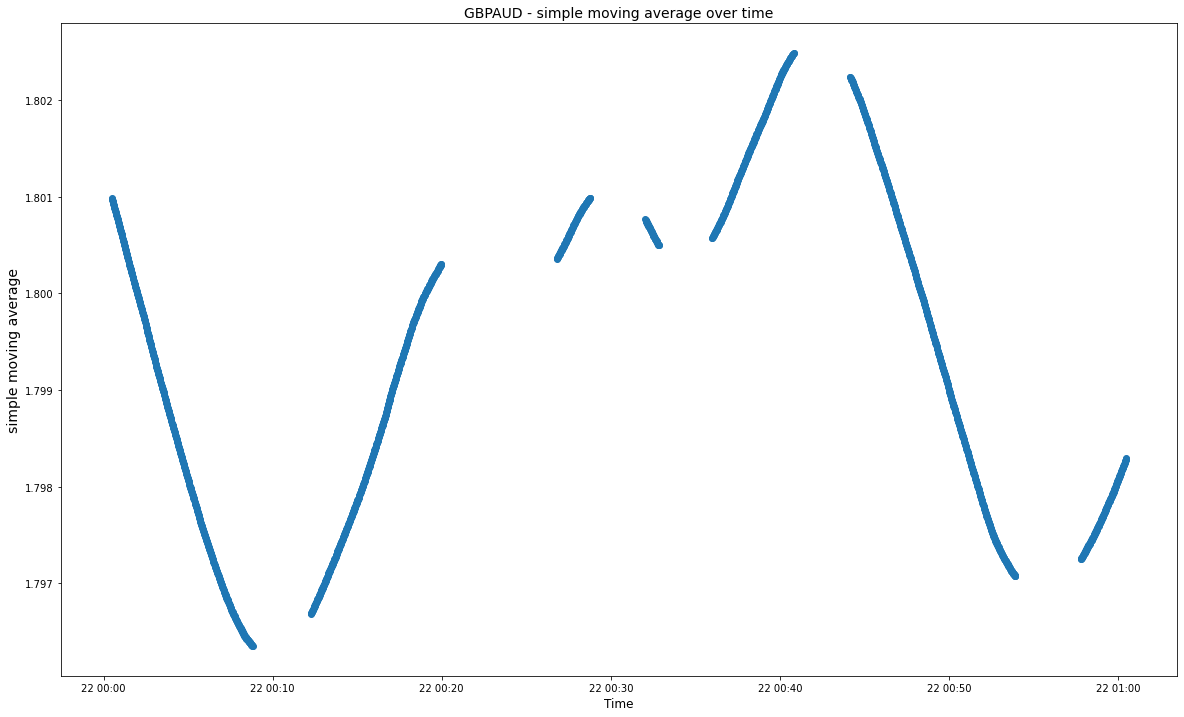

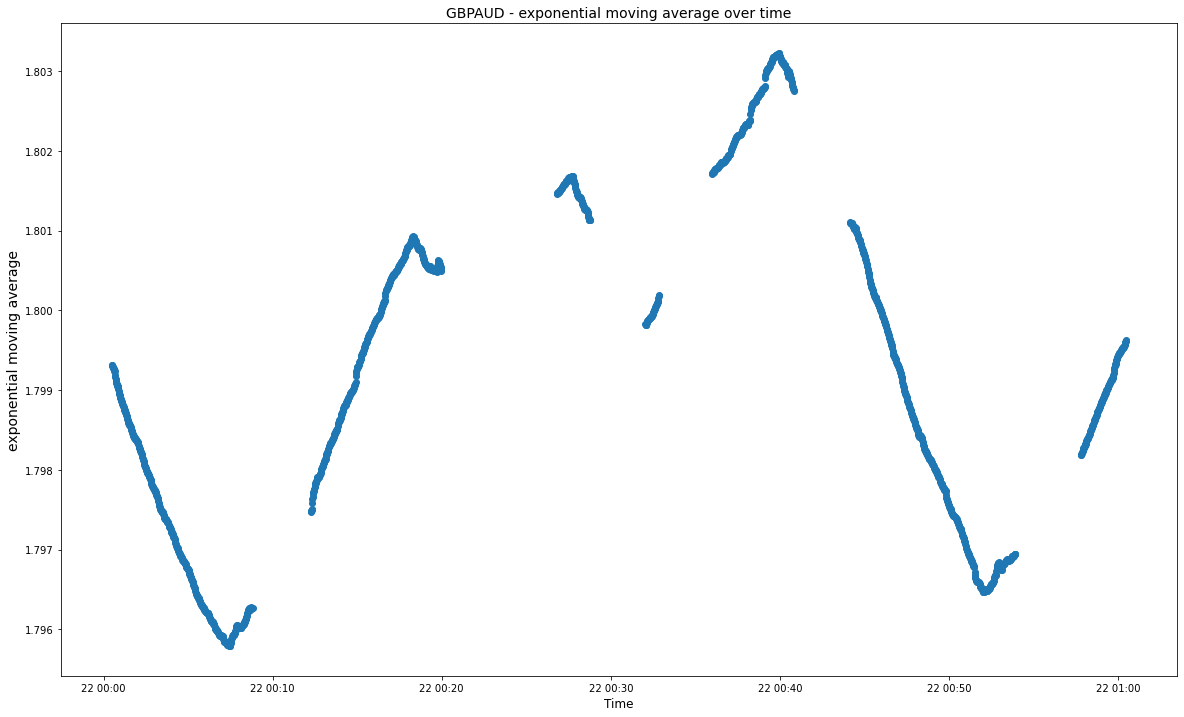

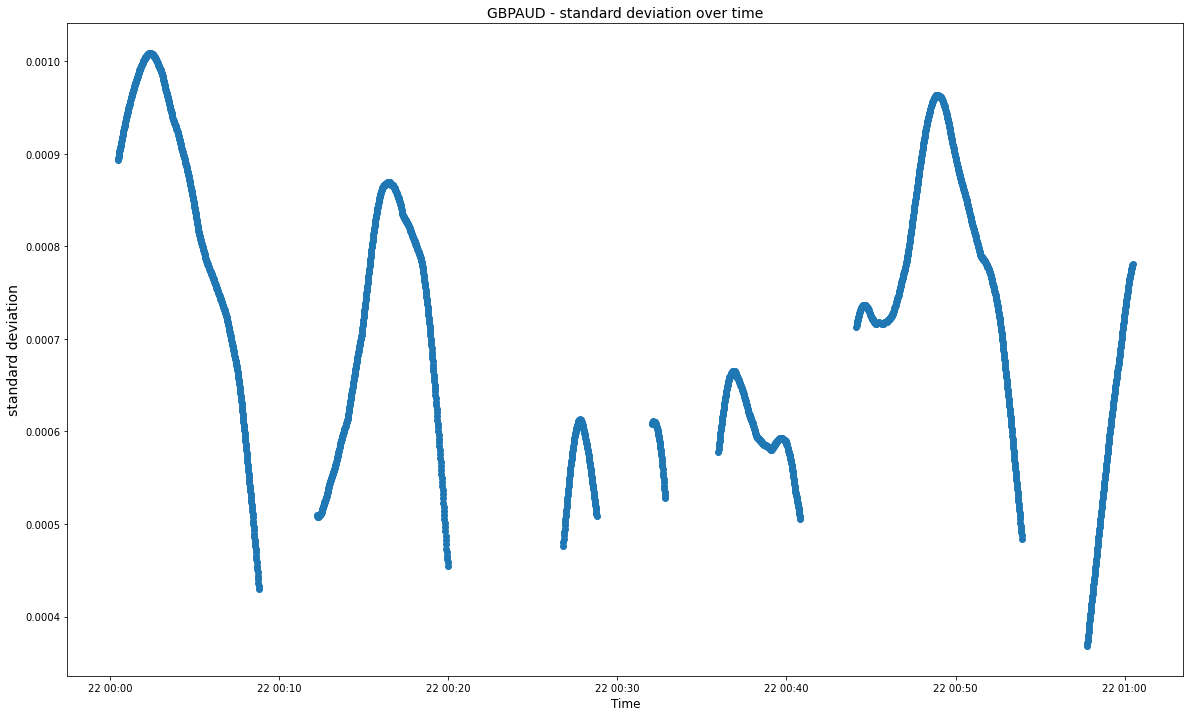

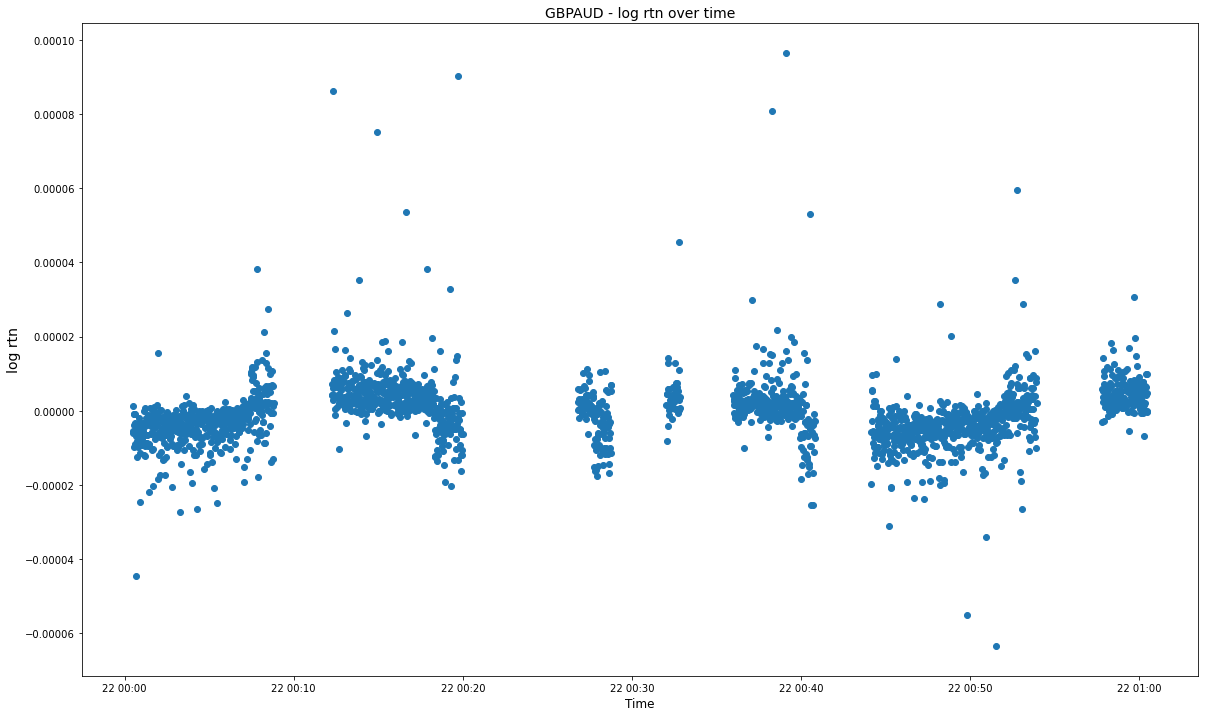

In [8]:
def plot_feature_over_time(data, metric_name, filter_time=1):
    
    if filter_time:
        data = data[data.index < data.index.min()+timedelta(hours=filter_time)].copy()
    
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.scatter(data.index, data[metric_name])
    plt.title(f'''{CCY_PAIR} - {metric_name.lower().replace('_', ' ')} over time''', fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel(metric_name.lower().replace('_', ' '), fontsize=14)
    fig.show()


for metric in METRIC_COLUMNS:
    plot_feature_over_time(training_data_df, metric)

#### Plot histograms of training data

The histograms below illustrate the distributions of each feature that the model is tasked to learn.

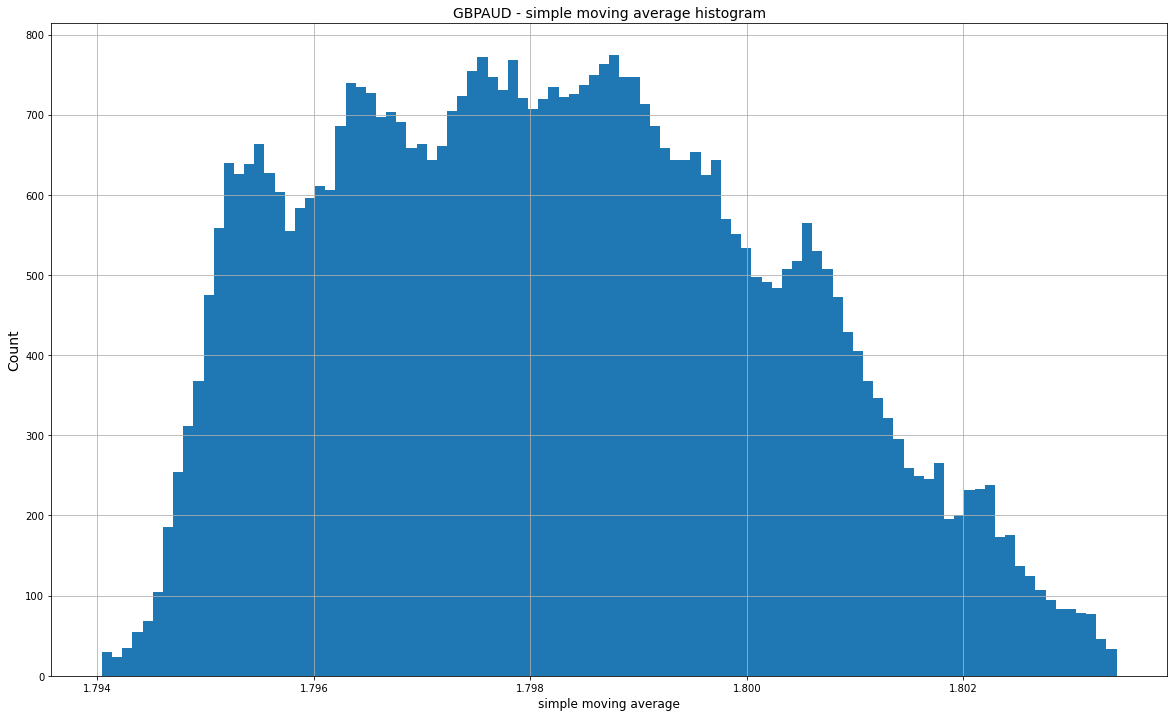

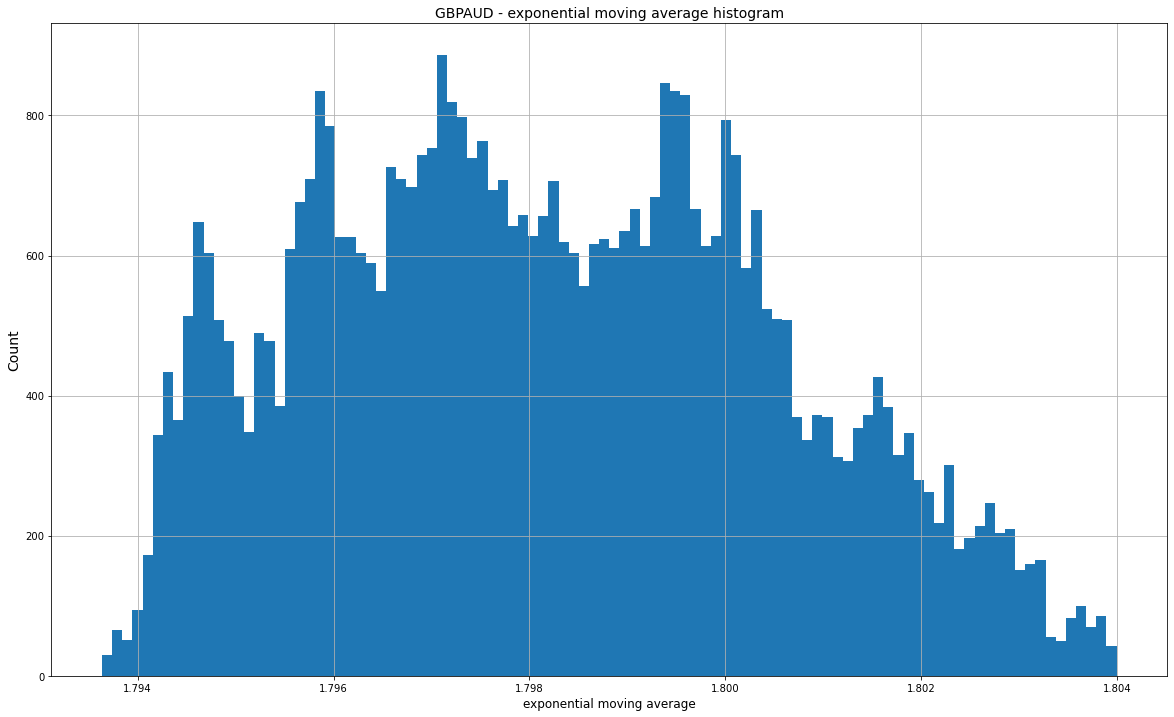

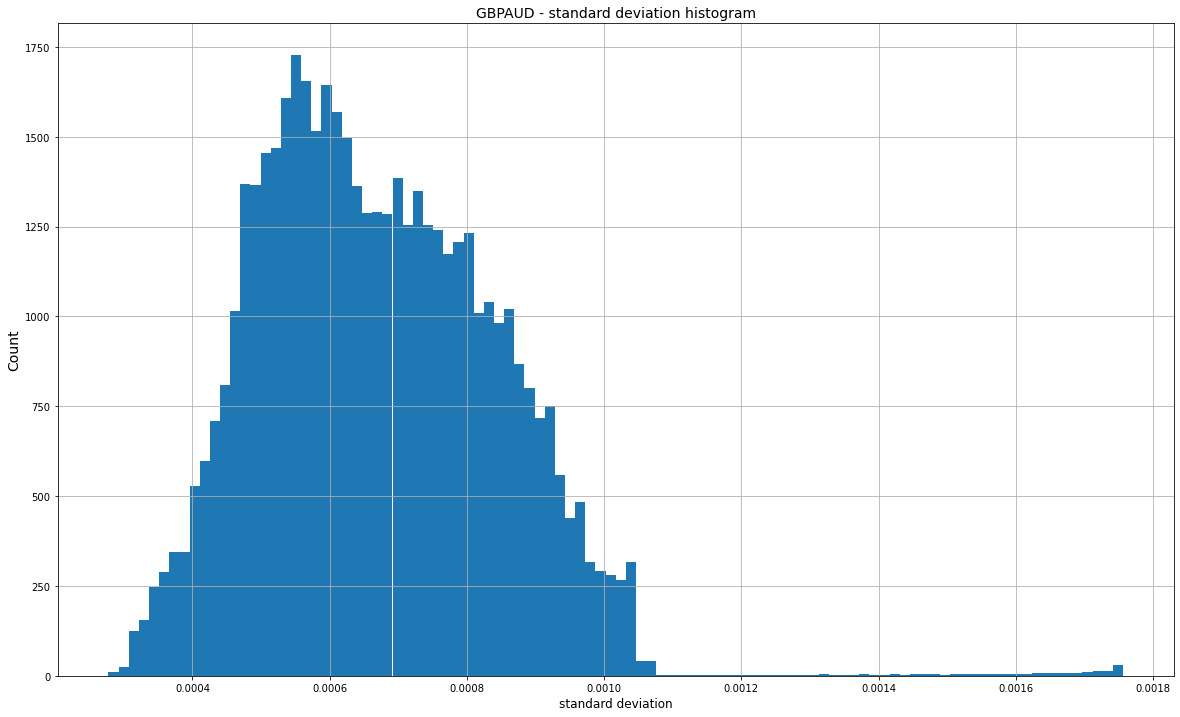

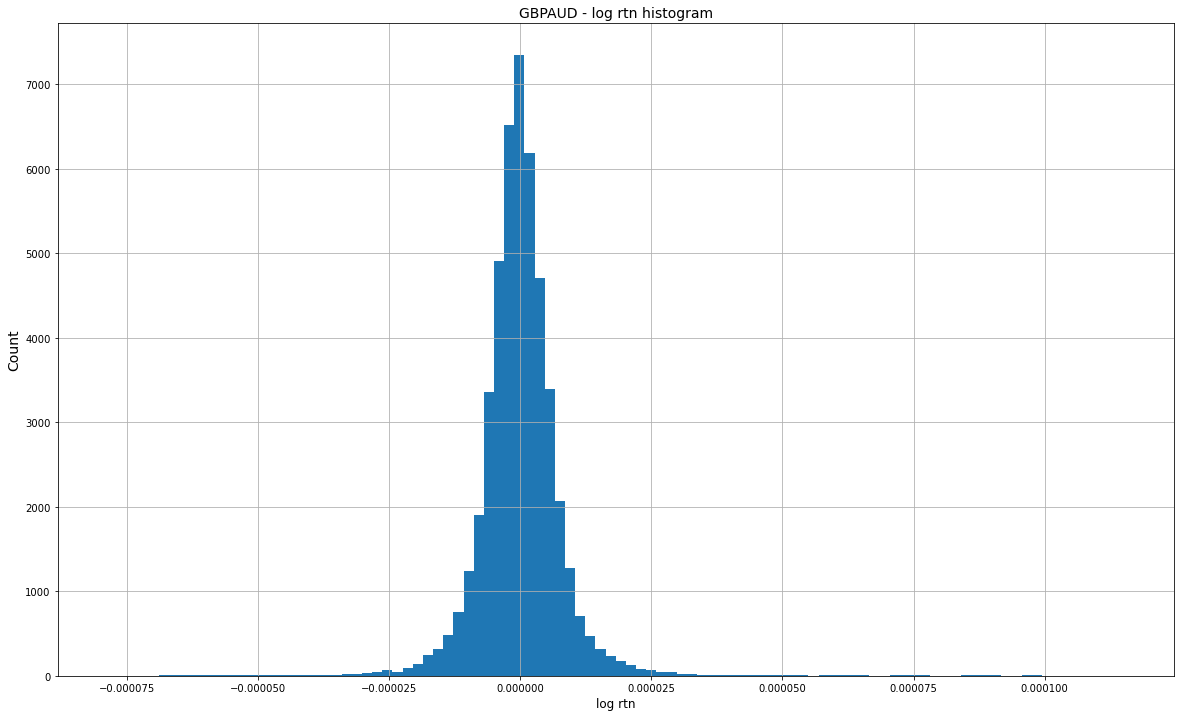

In [9]:
def plot_histogram_of_features(data, metric):
    fig, ax = plt.subplots(figsize=(20, 12))
    data.hist(metric, bins=100, ax=ax)
    plt.title(f'''GBPAUD - {metric.lower().replace('_', ' ')} histogram''', fontsize=14)
    plt.xlabel(metric.lower().replace('_', ' '), fontsize=12)
    plt.ylabel("Count", fontsize=14)
    plt.show()

    
for metric in METRIC_COLUMNS:
    plot_histogram_of_features(training_data_df, metric)

### StatisticsGen component

This component computes statistics of the data for understanding, visualization, and validation.

In [10]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples']
)

context.run(statistics_gen)
context.show(statistics_gen.outputs['statistics'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for StatisticsGen
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmpr6pvh13v/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmpr6pvh13v/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmpr6pvh13v/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmpr6pvh13v/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Generating statistics for split train.
INFO:absl:Statistics for split train written to pipelines/forex-example-pipeline/StatisticsGen/statistics/2/train.
INFO:absl:Generating statistics for split eval.
INFO:absl:Statistics for split eval written to pipelines/forex-example-pipeline/StatisticsGen/statistics/2/e

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


### SchemaGen component

This component generates the schema of the data based on the StatisticsGen component output.

In [11]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True
)

context.run(schema_gen)
context.show(schema_gen.outputs['schema'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for SchemaGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for SchemaGen
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmplc0zn9ui/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmplc0zn9ui/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmplc0zn9ui/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmplc0zn9ui/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Processing schema from statistics for split train.
INFO:absl:Processing schema from statistics for split eval.
INFO:absl:Schema written to pipelines/forex-example-pipeline/SchemaGen/schema/3/schema.pbtxt.
INFO:absl:Running publisher for SchemaGen
INFO:absl:MetadataStore with DB connection initialized


,Type,Presence,Valency,Domain
Feature name,,,,
'EXPONENTIAL_MOVING_AVERAGE',FLOAT,required,,-
'LOG_RTN',FLOAT,required,,-
'SIMPLE_MOVING_AVERAGE',FLOAT,required,,-
'STANDARD_DEVIATION',FLOAT,required,,-
'timestamp',INT,required,,-


The schema of the input feature tensors is shown below. As expected, each feature has a dimension of size 60 (the window size).

In [12]:
schema = tfx.utils.io_utils.SchemaReader().read(
    tfx.utils.io_utils.get_only_uri_in_dir(
        tfx.types.artifact_utils.get_single_uri(schema_gen.outputs['schema'].get())))

print(schema)

feature {
  name: "EXPONENTIAL_MOVING_AVERAGE"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 30
    }
  }
}
feature {
  name: "LOG_RTN"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 30
    }
  }
}
feature {
  name: "SIMPLE_MOVING_AVERAGE"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 30
    }
  }
}
feature {
  name: "STANDARD_DEVIATION"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 30
    }
  }
}
feature {
  name: "timestamp"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 30
    }
  }
}



### ExampleValidator component

This component performs anomaly detection based on statistics describing the data and schema of the data.

In [13]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

context.run(example_validator)
context.show(example_validator.outputs['anomalies'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for ExampleValidator
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for ExampleValidator
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmptri19ck_/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmptri19ck_/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmptri19ck_/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmptri19ck_/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Validating schema against the computed statistics for split train.
INFO:absl:Validation complete for split train. Anomalies written to pipelines/forex-example-pipeline/ExampleValidator/anomalies/4/train.
INFO:absl:Validating schema against the computed statistics for split eval.
INFO:absl:Validation com

/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/utils/display_util.py:188: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


### Transform component

The Transform component transforms the data read by the ExampleGen component into features ready for the model. <br>
This particular transform component ensures the correct metrics are inputted as features and scales them each by the z-score function.

In [14]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file='../app/python/src/tfx_components/transformer.py', # Update this path according to your notebook's working directory
    custom_config={
        'feature_columns': METRIC_COLUMNS
    },
)
context.run(transform, enable_cache=False)

INFO:absl:Running driver for Transform
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Transform
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmp9c2p8fkv/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmp9c2p8fkv/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmp9c2p8fkv/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmp9c2p8fkv/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Analyze the 'train' split and transform all splits when splits_config is not set.


Instructions for updating:
Schema is a deprecated, use schema_utils.schema_from_feature_spec to create a `Schema`


INFO:absl:Loading ../app/python/src/tfx_components/transformer.py because it has not been loaded before.
INFO:absl:../app/python/src/tfx_components/transformer.py is already loaded.
INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_RTN has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature SIMPLE_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature STANDARD_DEVIATION has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature timestamp has a shape dim {
  size: 30
}
. Setting to DenseTensor.


Instructions for updating:
Use ref() instead.


INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_RTN has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature SIMPLE_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature STANDARD_DEVIATION has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature timestamp has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_RTN has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature SIMPLE_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature STANDARD_DEVIATION has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature timestamp has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. 

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: pipelines/forex-example-pipeline/Transform/transform_graph/5/.temp_path/tftransform_tmp/99dab4627a784f28b6f65dc5d28ed6b7/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: pipelines/forex-example-pipeline/Transform/transform_graph/5/.temp_path/tf

INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_RTN has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature SIMPLE_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature STANDARD_DEVIATION has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature timestamp has a shape dim {
  size: 30
}
. Setting to DenseTensor.


INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_RTN has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature SIMPLE_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature STANDARD_DEVIATION has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature timestamp has a shape dim {
  size: 30
}
. Setting to DenseTensor.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: pipelines/forex-example-pipeline/Transform/transform_graph/5/.temp_path/tftransform_tmp/a11183913f1a4088be5cfff18f4efcd5/saved_model.pb
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:absl:Running publisher for Transform
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 5
        type_id: 13
        uri: "pipelines/forex-example-pipeline/Transform/transform_graph/5"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 6
        type_id: 5
        uri: "pipelines/forex-example-pipeline/Transform/transformed_examples/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 7
        type_id: 14
        uri: "pipelines/forex-example-pipeline/Transform/updated_analyzer_cache/5"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

#### Extract output of Transform

Use the function below to convert the output of Transform component into a Pandas dataframe.

In [15]:
def convert_transform_output_to_pandas_df(transform, example_gen_output_df, train_or_eval = 'train'):
    
    # Get the URI of the output artifact
    train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, train_or_eval)

    # Get the list of files in this directory (all compressed TFRecord files)
    tfrecord_filenames = [os.path.join(train_uri, name)
                          for name in os.listdir(train_uri)]

    # Create a `TFRecordDataset` to read these files
    dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
    
    output = []
    for tfrecord in dataset.take(example_gen_output_df.shape[0]):
        # Parse tfrecord to proto
        serialized_example = tfrecord.numpy()
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        features = example.features.feature
        
        # Convert proto to dict - note this extracts only the last element of each window
        instance = {}
        for key in features:
            
            if key == 'timestamp':
                # Extract the time bounds
                instance['end_time'] = datetime.fromtimestamp(int(features['timestamp'].int64_list.value[WINDOW_SIZE-1]))
            else:
                # Extract data
                instance[key] = features[key].float_list.value[WINDOW_SIZE-1]
        
        # Append instance as dict to list
        output.append(instance)
    
    
    df = pd.DataFrame(output)
    df['end_time'] = example_gen_output_df.index
    df.set_index('end_time', inplace=True)
    df.sort_index(inplace=True)
    
    return df


features_df = convert_transform_output_to_pandas_df(transform, training_data_df)
features_df.head()

,SIMPLE_MOVING_AVERAGE,LOG_RTN,EXPONENTIAL_MOVING_AVERAGE,STANDARD_DEVIATION
end_time,,,,
2021-05-22 00:00:29,1.350882,-0.622601,0.476746,1.281424
2021-05-22 00:00:30,1.345340,0.140595,0.475043,1.290976
2021-05-22 00:00:31,1.339855,-0.680486,0.471947,1.301221
2021-05-22 00:00:32,1.334429,-1.130083,0.466580,1.312398
2021-05-22 00:00:33,1.329003,-0.107333,0.463484,1.322936


#### Plot transformed features over time

The transformed features are plotted over time. Let's check these plots are similar to the plots of the raw training data. They should be very similar as the only difference between the raw and transformed features is scaling by the z-score function.

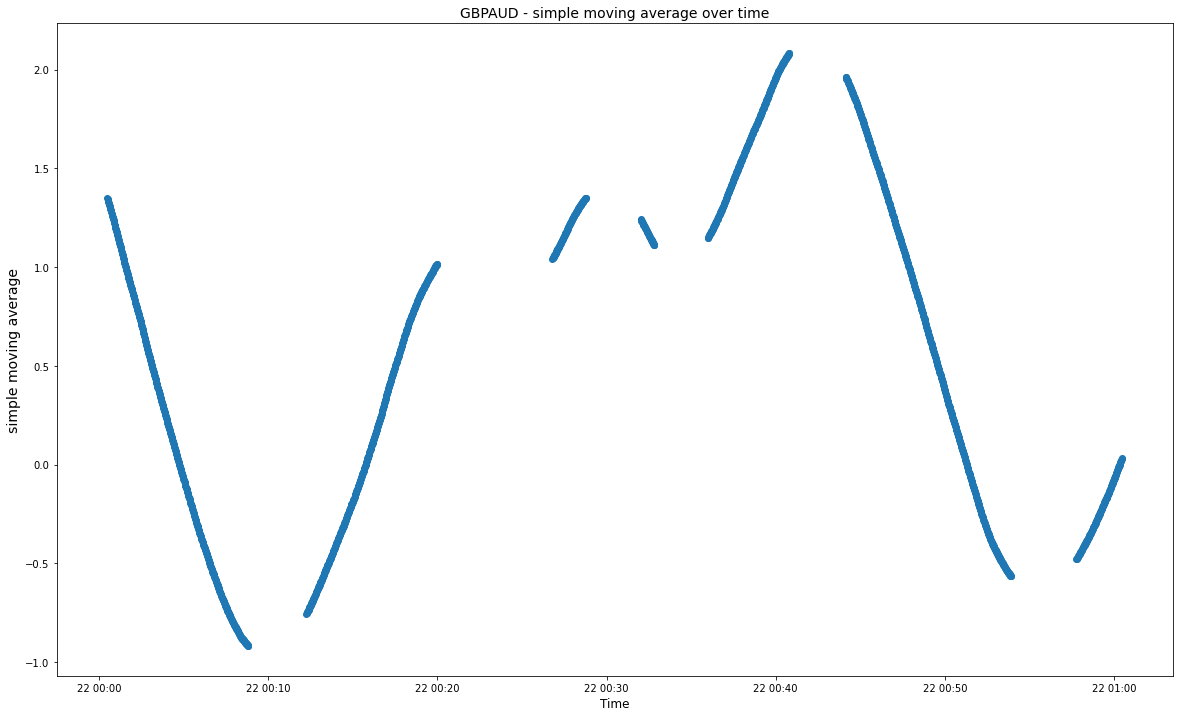

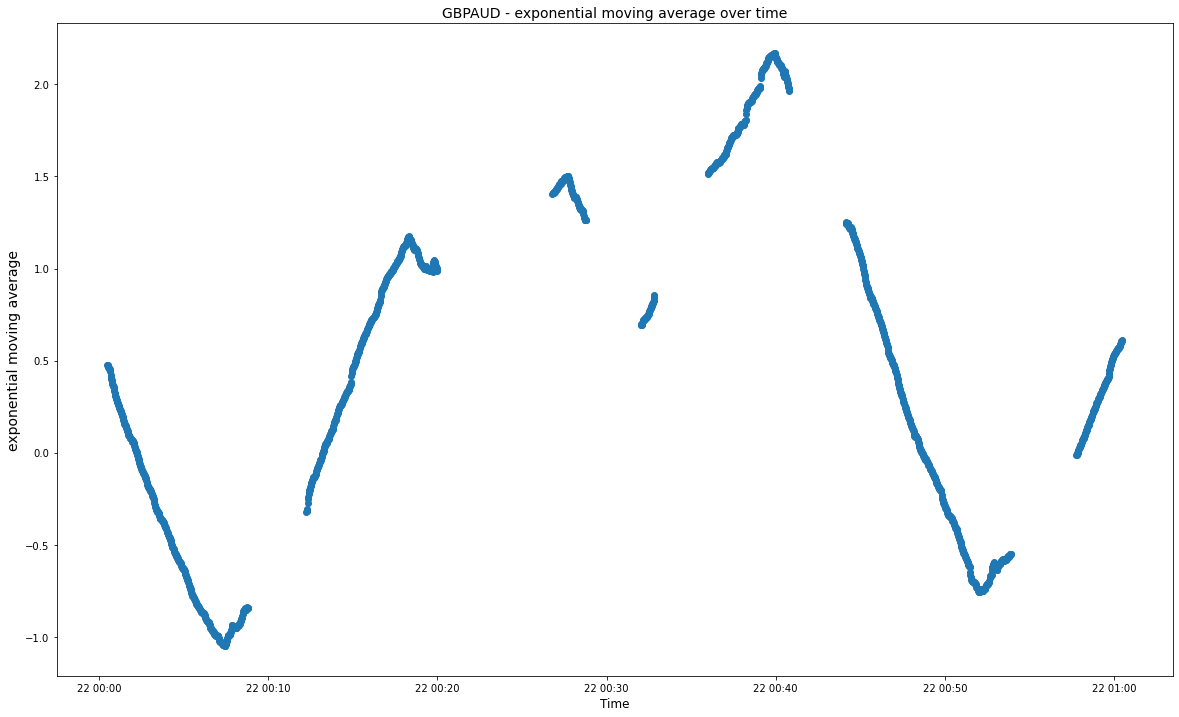

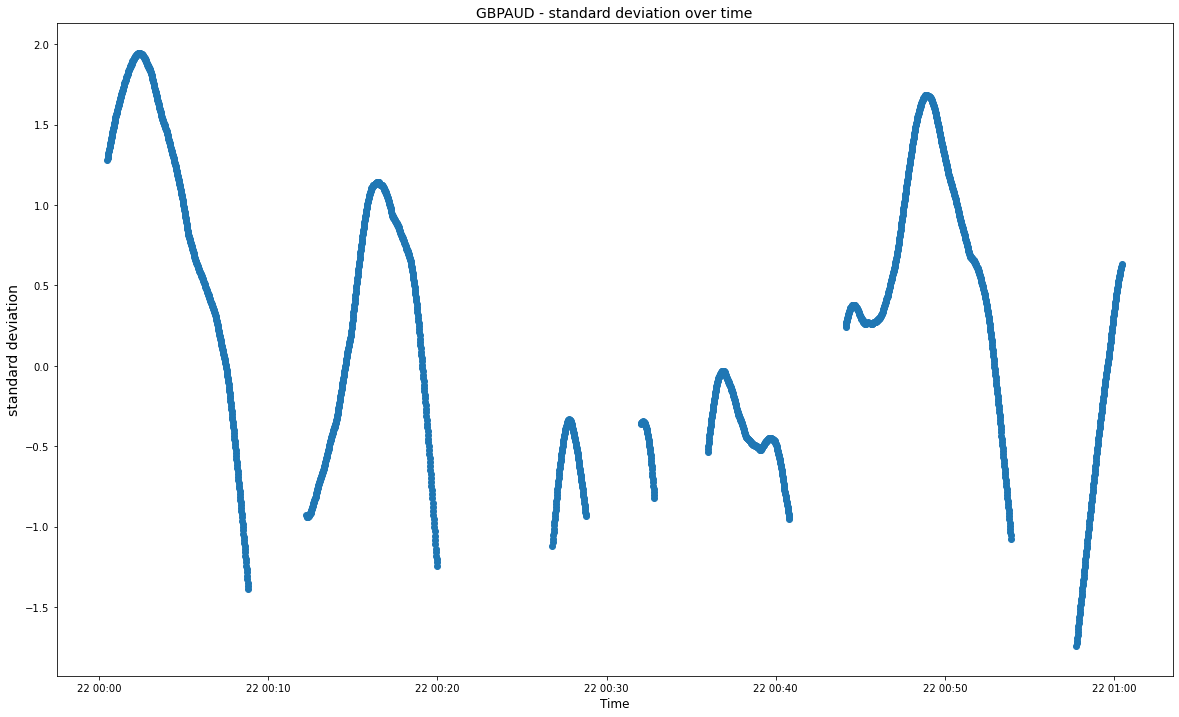

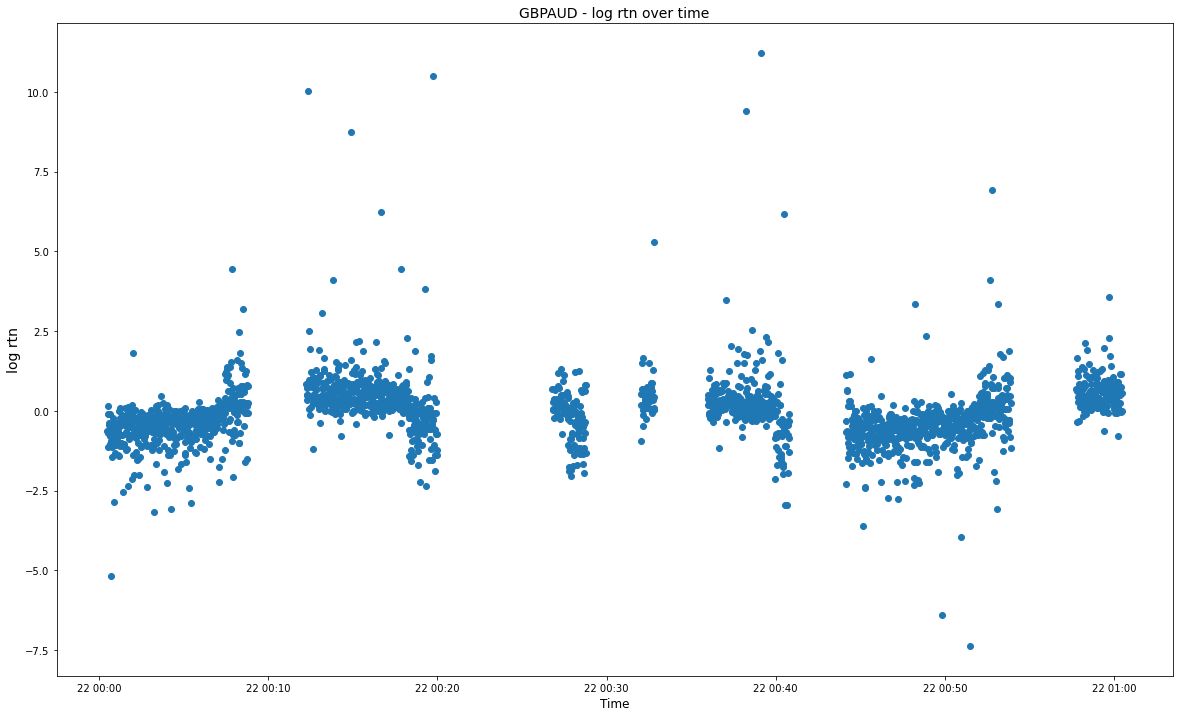

In [16]:
def plot_metric_over_time(data, metric_name, filter_time=1):
    
    if filter_time:
        data = data[data.index < data.index.min()+timedelta(hours=filter_time)].copy()
    
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.scatter(data.index, data[metric_name])
    plt.title(f'''{CCY_PAIR} - {metric_name.lower().replace('_', ' ')} over time''', fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel(metric_name.lower().replace('_', ' '), fontsize=14)
    fig.show()


for metric in METRIC_COLUMNS:
    plot_feature_over_time(features_df, metric)

### Trainer component

The Trainer component trains the LSTM autoencoder with the 4 features plotted above as both the model's inputs and outputs. The model is tasked to 'reconstruct' the inputs and by doing so learns a latent representation of the features. Then at inference time, if the input features display a significantly different latent representation than what was learned at training time, we can say this is an anomaly.

In [17]:
trainer = Trainer(
    module_file='../app/python/src/tfx_components/trainer.py', # Update this path according to your notebook's working directory
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(num_steps=2700), # steps for 1 epoch = (instances in 1 day of training data) / batch_size = 60*60*24/32 = 2700
    eval_args=trainer_pb2.EvalArgs(num_steps=2700),
    custom_config={
        'input_features': METRIC_COLUMNS,
        'window_size': WINDOW_SIZE,
        'outer_units': OUTER_UNITS,
        'inner_units': INNER_UNITS,
        'batch_size': BATCH_SIZE
    },
)
context.run(trainer, enable_cache=False)

INFO:absl:Running driver for Trainer
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Trainer
INFO:absl:Attempting to infer TFX Python dependency for beam
INFO:absl:Copying all content from install dir /opt/conda/lib/python3.7/site-packages/tfx to temp dir /tmp/tmpqm4ornpj/build/tfx
INFO:absl:Generating a temp setup file at /tmp/tmpqm4ornpj/build/tfx/setup.py
INFO:absl:Creating temporary sdist package, logs available at /tmp/tmpqm4ornpj/build/tfx/setup.log
INFO:absl:Added --extra_package=/tmp/tmpqm4ornpj/build/tfx/dist/tfx_ephemeral-0.28.0.tar.gz to beam args
INFO:absl:Train on the 'train' split when train_args.splits is not set.
INFO:absl:Evaluate on the 'eval' split when eval_args.splits is not set.
INFO:absl:Loading ../app/python/src/tfx_components/trainer.py because it has not been loaded before.
INFO:absl:Training model.
INFO:absl:Feature EXPONENTIAL_MOVING_AVERAGE has a shape dim {
  size: 30
}
. Setting to DenseTensor.
INFO:absl:Feature LOG_R

2700/2700 [==============================] - ETA: 6:14:44 - loss: 312.2188 - mse: 312.21 - ETA: 21:16 - loss: 307.2174 - mse: 307.2174 - ETA: 26:53 - loss: 301.0145 - mse: 301.01 - ETA: 20:57 - loss: 300.0779 - mse: 300.07 - ETA: 17:38 - loss: 297.5027 - mse: 297.50 - ETA: 15:31 - loss: 294.7131 - mse: 294.71 - ETA: 14:04 - loss: 293.5229 - mse: 293.52 - ETA: 13:05 - loss: 292.0501 - mse: 292.05 - ETA: 12:28 - loss: 290.0609 - mse: 290.06 - ETA: 11:59 - loss: 288.5530 - mse: 288.55 - ETA: 11:33 - loss: 287.0122 - mse: 287.01 - ETA: 11:08 - loss: 285.4836 - mse: 285.48 - ETA: 10:45 - loss: 283.9766 - mse: 283.97 - ETA: 10:28 - loss: 282.4078 - mse: 282.40 - ETA: 10:18 - loss: 280.8529 - mse: 280.85 - ETA: 10:06 - loss: 279.2492 - mse: 279.24 - ETA: 9:57 - loss: 277.8369 - mse: 277.8369 - ETA: 9:50 - loss: 276.3635 - mse: 276.363 - ETA: 9:46 - loss: 275.0060 - mse: 275.006 - ETA: 9:38 - loss: 273.7527 - mse: 273.752 - ETA: 9:27 - loss: 272.6646 - mse: 272.664 - ETA: 9:18 - loss: 271.5993

INFO:absl:Training complete. Model written to pipelines/forex-example-pipeline/Trainer/model/6/serving_model_dir. ModelRun written to pipelines/forex-example-pipeline/Trainer/model_run/6
INFO:absl:Running publisher for Trainer
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Trainer
    execution_id: 6
    outputs:
        model: Channel(
            type_name: Model
            artifacts: [Artifact(artifact: id: 8
        type_id: 16
        uri: "pipelines/forex-example-pipeline/Trainer/model/6"
        custom_properties {
          key: "name"
          value {
            string_value: "model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "Model"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        model_run: Channel(
            type_name: ModelRun
            artifacts: [Artifact(artifact: id: 9
        type_id: 17
        uri: "pipelines/forex-example-pipeline/Trainer/model_run/6"
        custom_properties {
          key: "name"
          value {
            string_value: "model_run"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 17
        name: "ModelRun"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

The training dataset's MSE is 84.2, which is comparable to that of the evaluation dataset, 31.5. Additionally, the evaluation dataset's MSE is lower than the training dataset, which is desirable.

### Run model on evaluation dataset

Here we manually run the trained model on the evaluation dataset and compute the reconstruction error (RE). Anomalies are determined by comparing RE to a threshold. The threshold is selected by assuming a target anomaly rate of 10%. The anomalies are then plotted. <br>
Note that we must evaluate the model in this way because the TFX Evaluator component cannot be used as it currently does not handle model output variables created in the Transform component, which is a requirement for autoencoder models.

In [18]:
def evaluate_model(example_gen, transform, trainer, sample_size, target_anomaly_rate, train_or_eval = 'eval'):
    
    def get_tfrecord_dataset_from_tfx_component_output(component, component_name, train_or_eval):
        # Get the URI of the output artifact
        if component_name == 'example_gen':
            uri = os.path.join(component.outputs['examples'].get()[0].uri, train_or_eval)
        elif component_name == 'transform':
            uri = os.path.join(component.outputs['transformed_examples'].get()[0].uri, train_or_eval)
        
        # Get the list of files in this directory (all compressed TFRecord files)
        tfrecord_filenames = [os.path.join(uri, name)
                          for name in os.listdir(uri)]
        
        # Create a `TFRecordDataset` to read these files
        dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
        
        return dataset
    
    def get_tfexample_features_from_tfrecord(tfrecord):
        serialized_example = tfrecord.numpy()
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        features = example.features.feature
        return features
    
    def get_dict_from_tfexample(tfexample, component_name):
        instance = {}
        
        if component_name == 'example_gen':
            # Convert to dict of feature name to feature value (require for visualization of anomalies)
            for feature in tfexample:
                if feature == 'timestamp':
                    instance['end_time'] = datetime.fromtimestamp(
                        int(tfexample[feature].int64_list.value[WINDOW_SIZE-1])
                    )
                else:
                    instance[feature] = tfexample[feature].float_list.value[WINDOW_SIZE-1]
            
        
        elif component_name == 'transform':
            # Convert to dict of feature name to tensor (require tensor for model input)
            for feature in tfexample:
                instance[feature] = tf.constant(
                    [[tfexample[feature].float_list.value[w] for w in range(0, WINDOW_SIZE, 1)]], 
                    dtype='float32', name=feature
                )
        
        return instance
        
    def compute_reconstruction_error(features, output):
        # Compute reconstruction error using formula for squared error
        recon_error = 0
        for feature, output_feature in zip(METRIC_COLUMNS, output):
            _feature = features[feature].numpy()[0]
            _output_feature = np.array([i[0] for i in output_feature[0]])
            error = (_feature - _output_feature)**2
            recon_error += error.sum()
        
        return recon_error
    
    def compute_anomalies(data, threshold):
        # Compute anomalies by comparing reconstruction error to threshold
        def compare_recon_error_to_threshold(row, t):
            if row.recon_error >= t:
                return 1
            else:
                return 0
        
        data['anomaly'] = data.apply(lambda row: compare_recon_error_to_threshold(row, threshold), axis=1)
        num_pos_predictions = data[data['anomaly']==1].shape[0]
        
        return data, num_pos_predictions
    
    # Read raw and transformed data
    example_gen_dataset = get_tfrecord_dataset_from_tfx_component_output(example_gen, component_name='example_gen', train_or_eval=train_or_eval)
    transform_dataset = get_tfrecord_dataset_from_tfx_component_output(transform, component_name='transform', train_or_eval=train_or_eval)
    
    # Load model
    model = tf.keras.models.load_model(os.path.join(trainer.outputs['model'].get()[0].uri, 'serving_model_dir'))
    
    # Extract raw features and transformed features from TFX components simultaneously
    all_instances = []
    for example_tfrecord, transform_tfrecord in zip(example_gen_dataset.take(sample_size), transform_dataset.take(sample_size)):
        # Parse tfrecord to tfexample
        example_features = get_tfexample_features_from_tfrecord(example_tfrecord)
        transform_features = get_tfexample_features_from_tfrecord(transform_tfrecord)
        
        # Parse tfexample to dict
        raw_instance = get_dict_from_tfexample(example_features, 'example_gen')
        transformed_instance = get_dict_from_tfexample(transform_features, 'transform')
        
        # Compute model output and reconstruction error
        output = model.predict(transformed_instance)
        recon_error = compute_reconstruction_error(transformed_instance, output)
        raw_instance['recon_error'] = recon_error
        
        # Append instance as dict to list
        all_instances.append(raw_instance)
    
    # Create df with columns for the raw features and reconstruction error
    recon_error_df = pd.DataFrame(all_instances)
    recon_error_df.set_index('end_time', inplace=True)
    recon_error_df.sort_index(inplace=True)
    
    # Compute the required model threshold to achieve the target anomaly rate
    thresholds = [x for x in range(0, 500, 2)]
    for threshold in thresholds:
        anomalies_df, num_anomalies = compute_anomalies(recon_error_df, threshold)
        rate_of_anomalies = round(num_anomalies / anomalies_df.shape[0] * 100.0, 1)
        if rate_of_anomalies < target_anomaly_rate:
            print('threshold =', threshold)
            print('anomaly rate =', rate_of_anomalies)
            break
    
    return anomalies_df, threshold


TARGET_ANOMALY_RATE = 10 # percent
eval_df, threshold = evaluate_model(example_gen, transform, trainer, 10000, TARGET_ANOMALY_RATE)
eval_df.head()

threshold = 72
anomaly rate = 9.6


,LOG_RTN,STANDARD_DEVIATION,SIMPLE_MOVING_AVERAGE,EXPONENTIAL_MOVING_AVERAGE,recon_error,anomaly
end_time,,,,,,
2021-05-23 00:01:01,0.000005,0.000582,1.799695,1.800714,15.360397,0
2021-05-23 00:01:02,0.000007,0.000584,1.799701,1.800725,15.142635,0
2021-05-23 00:01:03,0.000004,0.000587,1.799706,1.800734,15.220174,0
2021-05-23 00:01:04,0.000004,0.000589,1.799711,1.800743,14.135132,0
2021-05-23 00:01:05,0.000004,0.000591,1.799717,1.800750,13.096101,0


With a target anomaly rate of 10%, the model threshold is 72.

#### Plot anomalies in evaluation dataset

Here the anomalies detected in the evaluation dataset are plotted in red against each of the model's features. <br>
When we see a red data point (anomaly), we can interpret this as: for the past 1 minute, the behaviour of the metrics is unexpected relative to how these metrics usually behave when RSI > 70 or RSI < 30, and thus RSI cannot be trusted to be reliable at this instant. <br> 
Notice that the anomalies exist when one feature or a combination of features have extreme values -- this is the expected behaviour. 

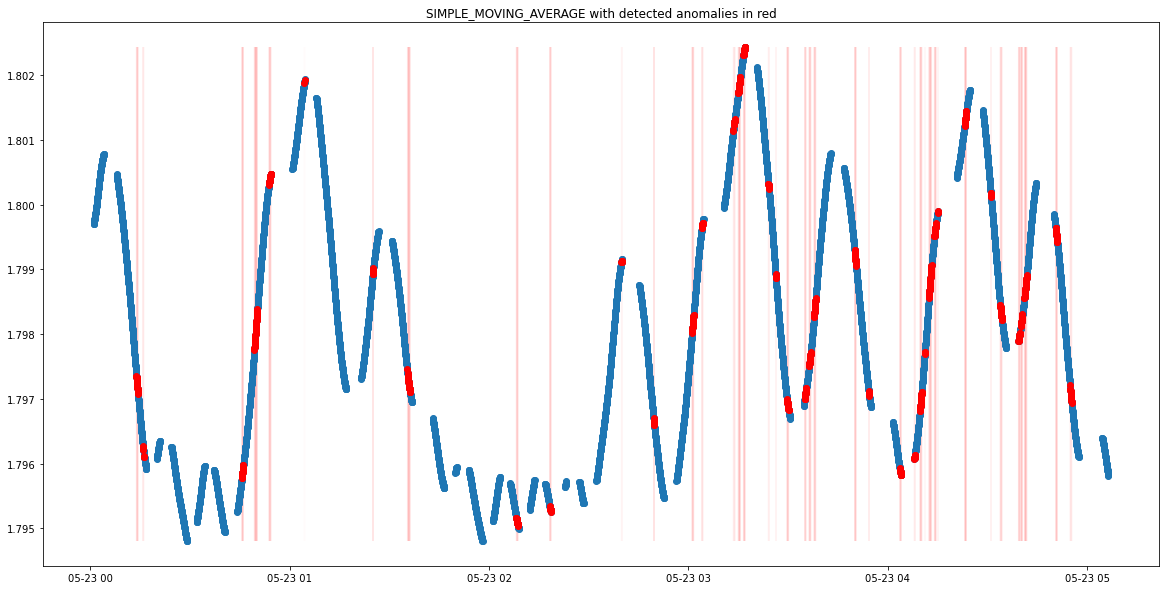

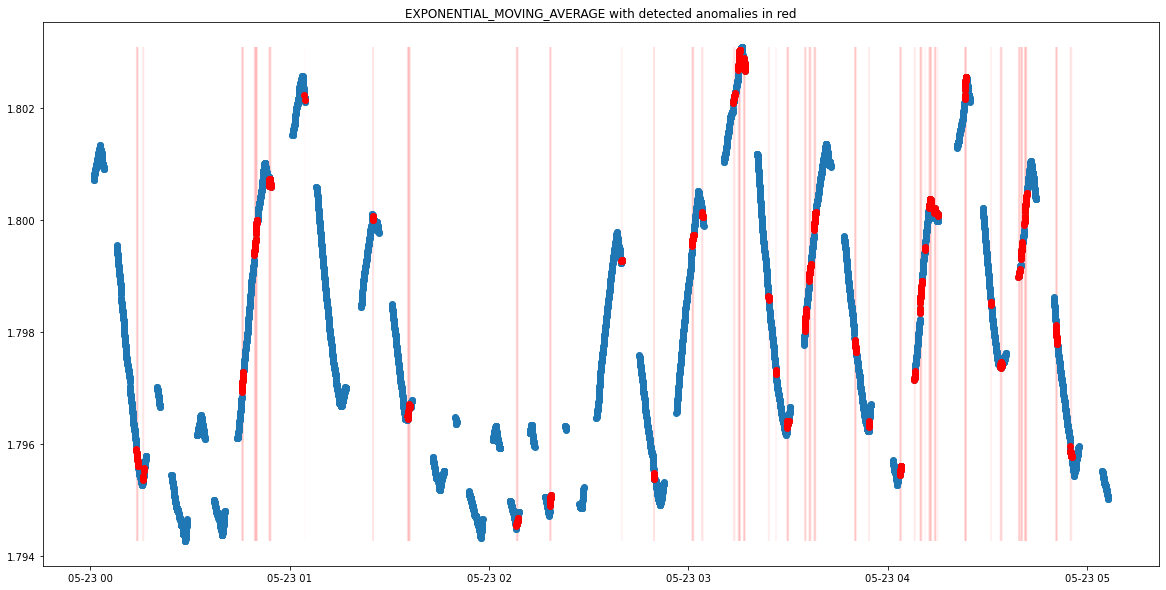

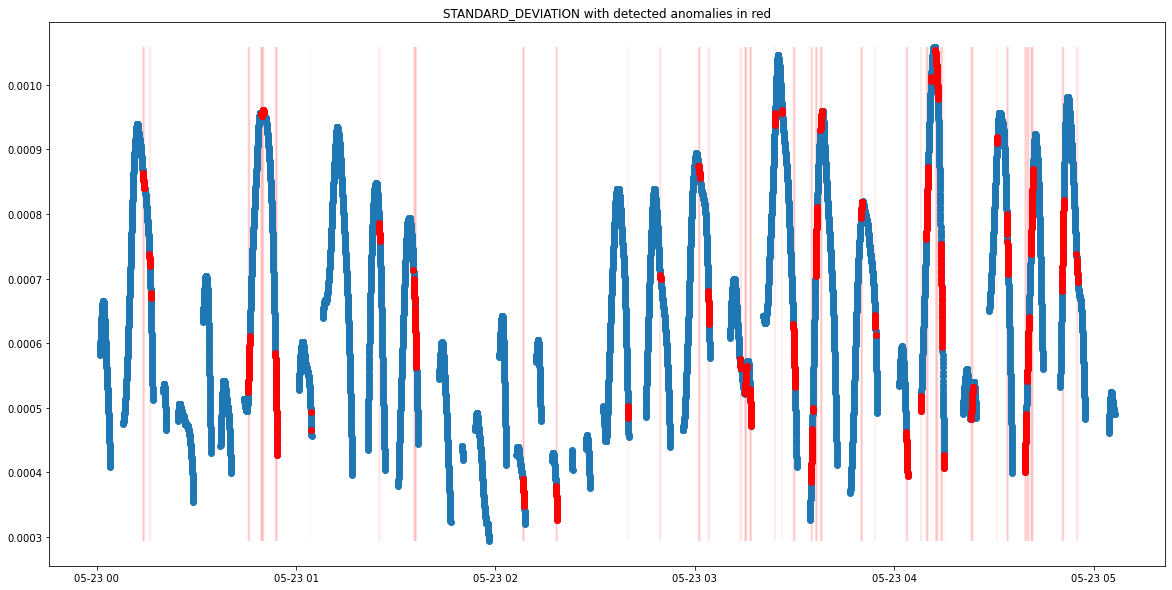

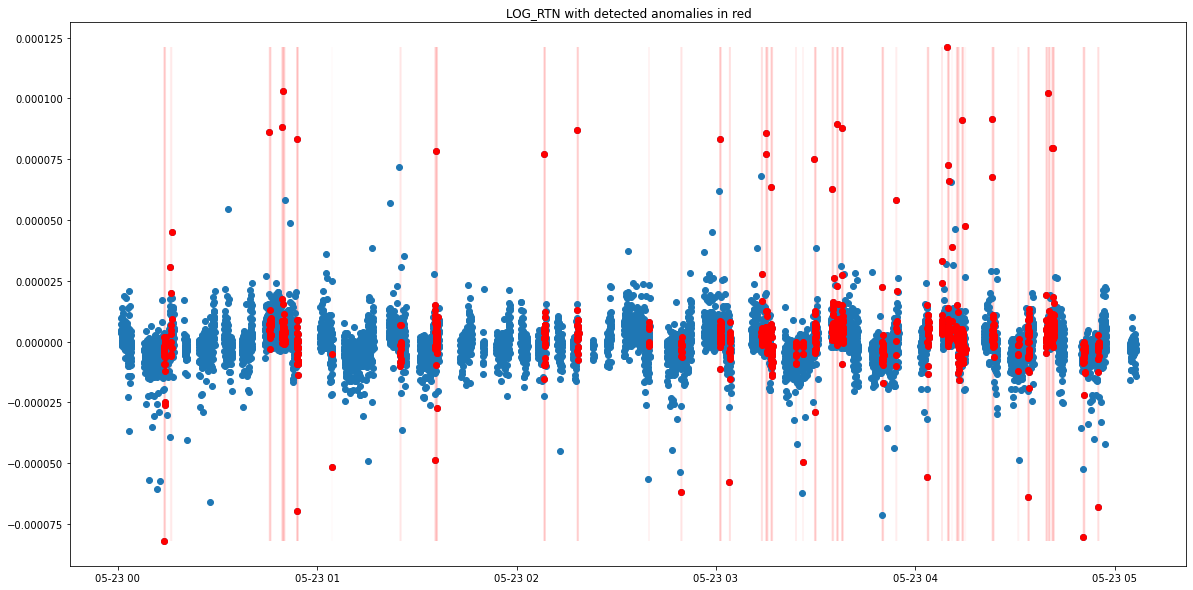

In [19]:
def plot_anomalies(data, metric_name):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot_date(x=data.index, y=data[metric_name])
    plt.plot_date(x=data[data['anomaly']==1].index, y=data[data['anomaly']==1][metric_name], color='red')
    ax.vlines(x=data[data['anomaly']==1].index.tolist(), \
              ymin=data[metric_name].min(), \
              ymax=data[metric_name].max(), \
              color="red", alpha=0.01)
    plt.title(f'''{metric_name} with detected anomalies in red''')
    fig.show()


for plot_feature in METRIC_COLUMNS:
    plot_anomalies(eval_df, plot_feature)

## Conclusion

This notebook has demonstrated how to develop a TFX training pipeline for a foreign exchange use case. The LSTM autoencoder model has shown that it is capable of its task - to detect anomalies in metrics describing the behaviour of the currency pair GBPAUD while RSI > 70 or RSI < 30.